In [5]:
%pip install numpy pandas geopandas matplotlib shapely geopy contextily --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Visualizing Singapore study area
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
import contextily as cx

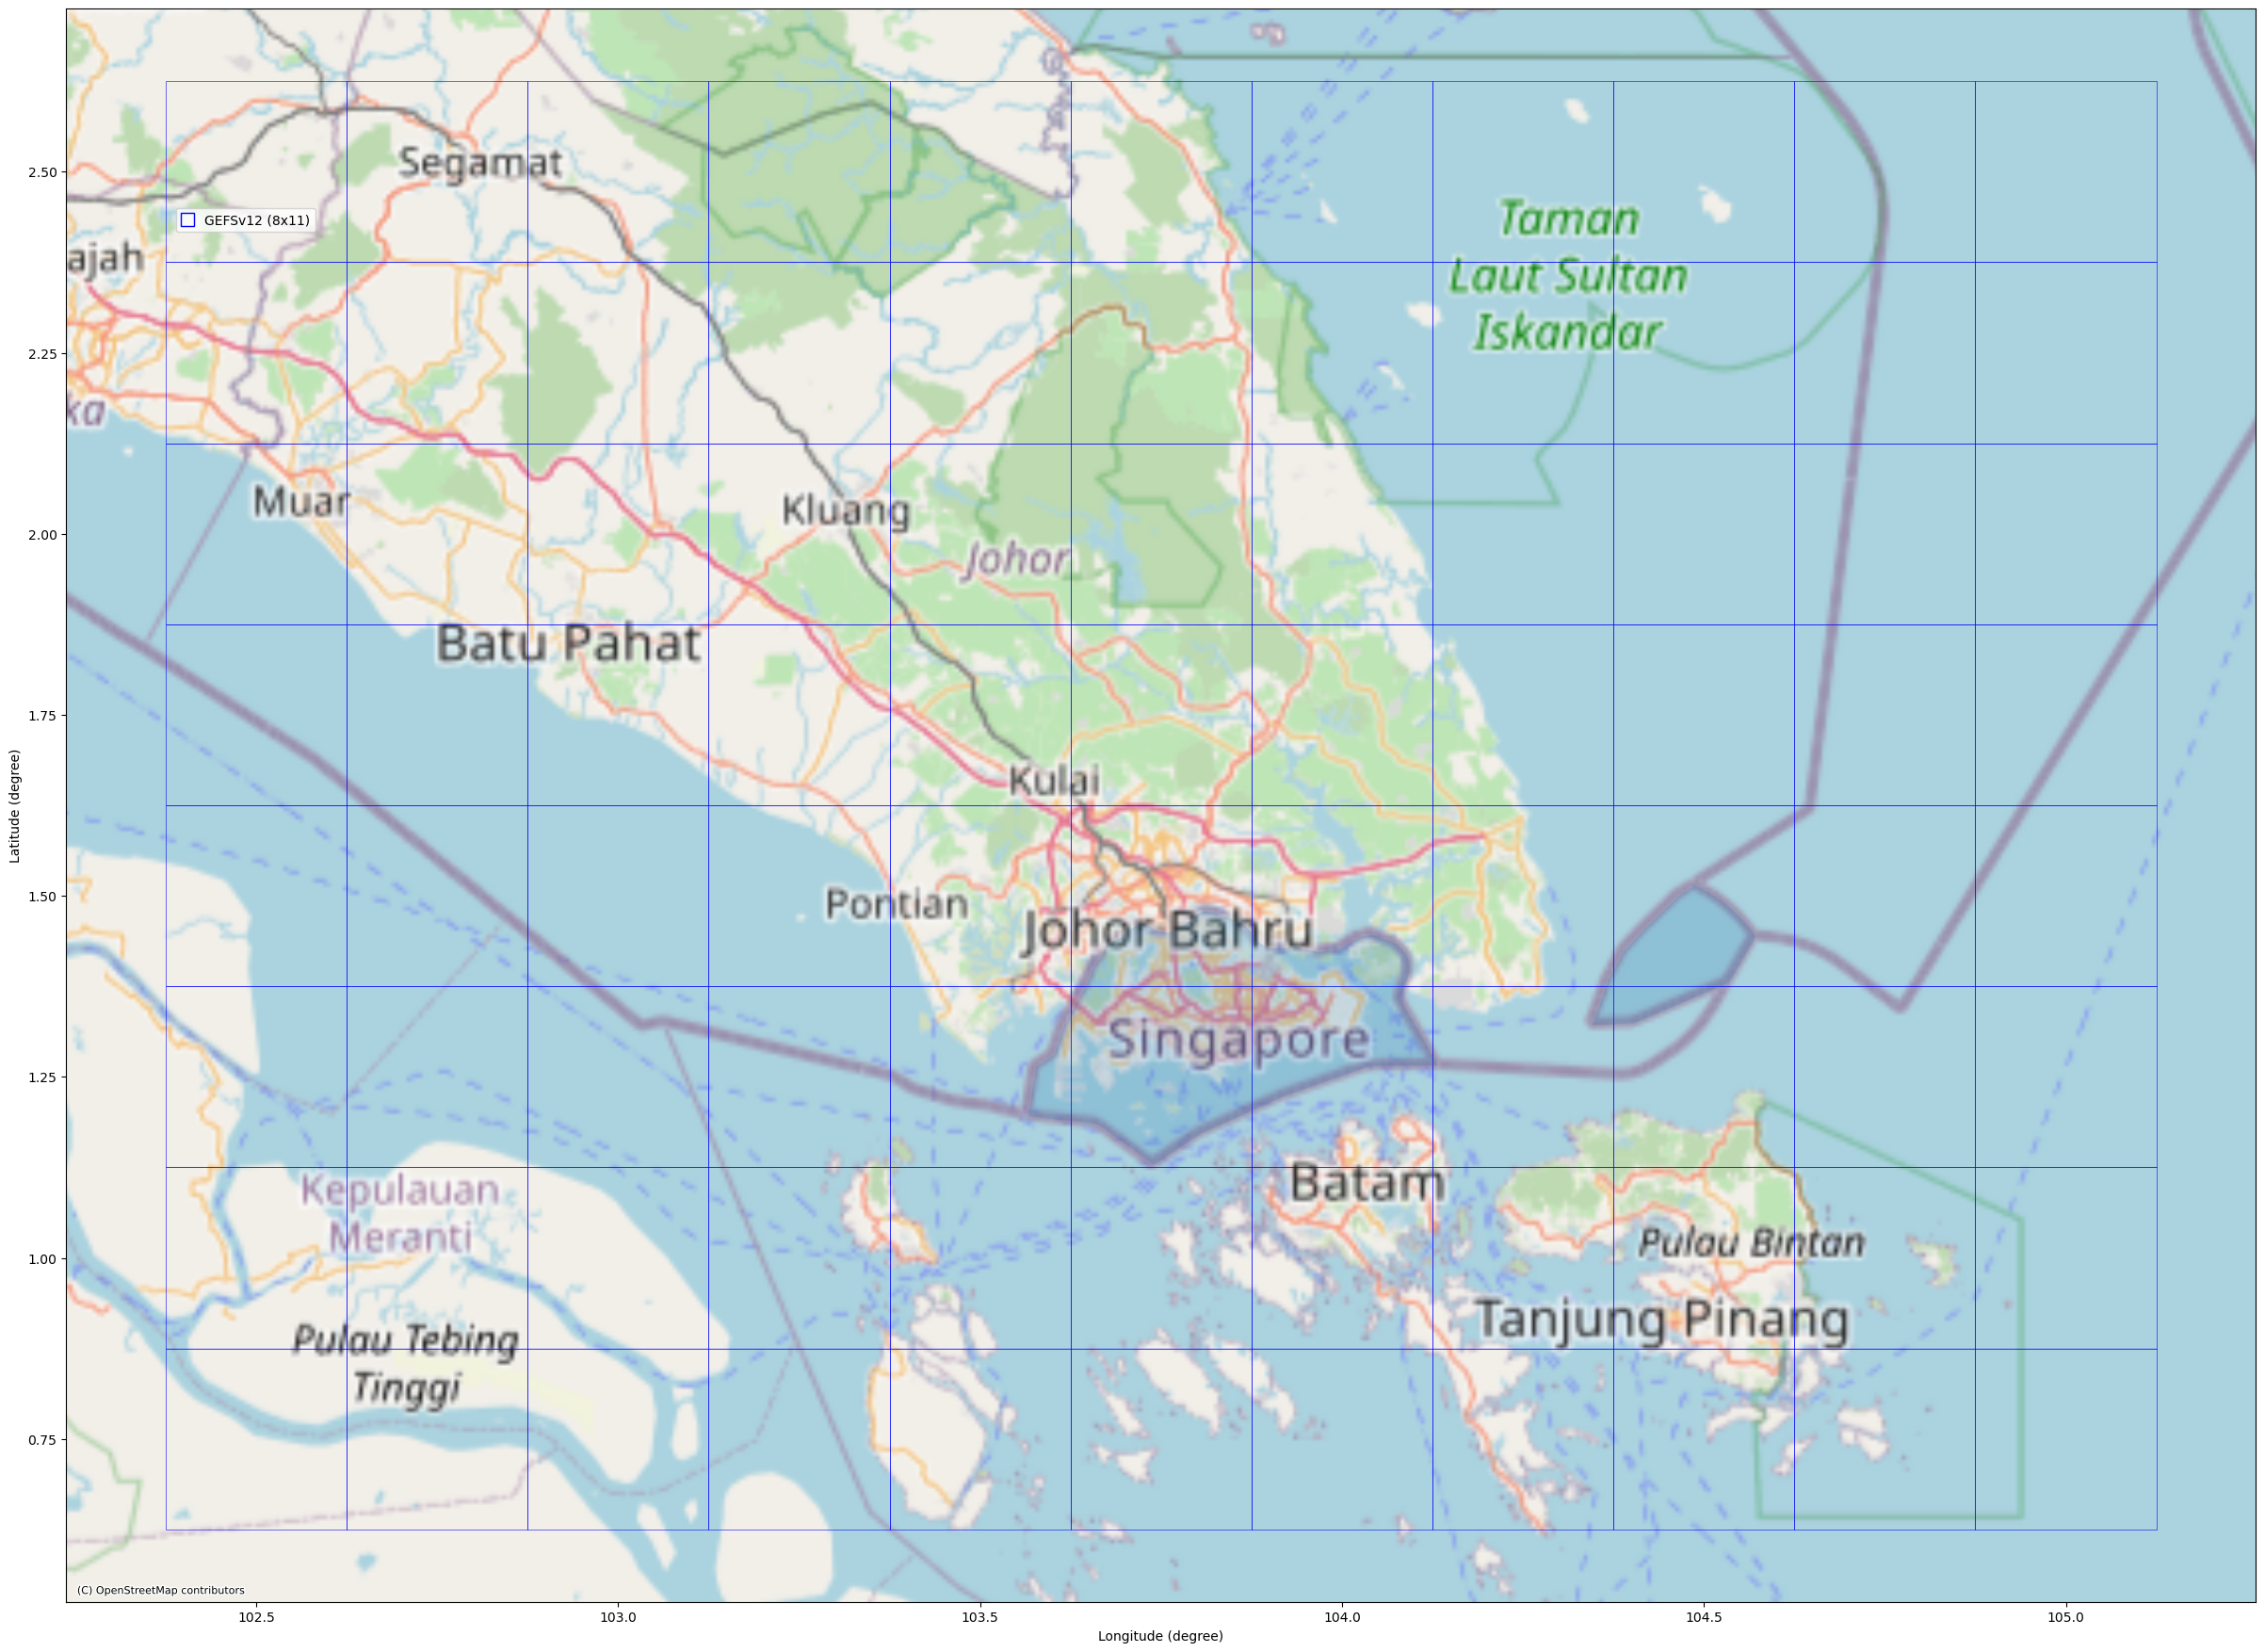

In [ ]:
def plot_grid(ax, lon, lat, width, length, edge_color, lw, point=False):
    """
    Function to plot a grid of rectangles on the given axes.

    Parameters:
        ax (matplotlib.axes._axes.Axes): The axes on which to plot the grid.
        lon (numpy.ndarray): Longitudes of the grid points.
        lat (numpy.ndarray): Latitudes of the grid points.
        width (float): Width of each rectangle.
        length (float): Length of each rectangle.
        edge_color (str): Color of the rectangle edges.
        lw (float): Line width of the rectangle edges.
        point (bool): Whether to plot points at the grid centers.
    """
    # Create rectangles for each grid point
    boxes = [Rectangle((x - width/2, y - length/2), width, length)
             for x, y in zip(lon.ravel(), lat.ravel())]

    # Create a PatchCollection from the rectangles
    data = PatchCollection(boxes, facecolor='none', edgecolor=edge_color, lw=lw)

    # Add the PatchCollection to the axes
    ax.add_collection(data)

    # Optionally plot points at the grid centers
    if point:
        ax.scatter(lon.ravel(), lat.ravel(), color=edge_color)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# GEFS grid settings
# The GEFS grid is a 2D grid with 8 latitudes and 11 longitudes
# The longitudes range from 102.5 to 105 degrees and the latitudes range from 0.75 to 2.5 degrees
# The grid points are the centers of the rectangles, so the width and length of each rectangle are 0.25
# The edge color of the rectangles is blue and the line width is 0.4
# The point argument is set to False, so the grid points are not plotted
lon_GEFS = np.linspace(102.5, 105, 11)
lat_GEFS = np.linspace(0.75, 2.5, 8)
lon, lat = np.meshgrid(lon_GEFS, lat_GEFS)
GEFS_setting = {
    'lon': lon,
    'lat': lat,
    'ax': ax,
    'width': 0.25,
    'length': 0.25,
    'edge_color': 'b',
    'lw': 0.4,
    'point': False
}

# Plot the GEFS grid on the axes using the plot_grid function
# The plot_grid function takes the axes and the GEFS grid settings as arguments
plot_grid(**GEFS_setting)

# Get the geometry data for Singapore using geopy and Nominatim (OpenStreetMap)
# The geometry data is a MultiPolygon, so we need to extract the Polygon objects
# and create a GeoDataFrame from them
location = lambda row: Nominatim(user_agent='google').geocode(row, geometry='geojson', timeout=10)
dic = location('Singapore').raw['geojson']

# Create a GeoDataFrame from the geometry data of Singapore
# The geometry data is a MultiPolygon, so we need to extract the Polygon
# objects and create a GeoDataFrame from them
df_list = []
for coords in dic['coordinates']:
    df = pd.DataFrame([dic])
    df['geometry'] = [Polygon(coords[0])]
    df_list.append(df)
df_combined = pd.concat(df_list, ignore_index=True)
gdf = gpd.GeoDataFrame(df_combined, crs="EPSG:4326", geometry=df_combined['geometry'])

# Plot the GeoDataFrame
gdf.plot(ax=ax, alpha=0.2)

# Add a basemap to the plot using contextily (OpenStreetMap)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) # type: ignore
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.Esri.WorldImagery)

# Create a legend for the plot
# The legend is created using a Patch object with facecolor='none' and edgecolor='b'
# This creates a blue rectangle with no fill, which is used as a legend item
legend_elements = [Patch(facecolor='none', edgecolor='b', label='GEFSv12 (8x11)')]
ax.legend(handles=legend_elements, loc=(0.05, 0.86), ncol=1, handlelength=1, handleheight=1.125)

# Set labels and save the figure
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.savefig('../figs/selected_WRF.png', dpi=1200, bbox_inches='tight')